# CAPSTON PROJECT : What will be the tesla stock price tomorrow?
Haowen Jiang
757515776jhw@gmail.com

## import the dataset

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rpaguirre/tesla-stock-price")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jhw75\.cache\kagglehub\datasets\rpaguirre\tesla-stock-price\versions\1


In [38]:
import pandas as pd

# Load the dataset
tesla_data = pd.read_csv('Tesla.csv')

print(tesla_data.info())


tesla_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB
None


,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
5,7/7/2010,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
6,7/8/2010,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
7,7/9/2010,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
8,7/12/2010,17.950001,18.070000,17.000000,17.049999,2202500,17.049999
9,7/13/2010,17.389999,18.639999,16.900000,18.139999,2680100,18.139999


## Data processing
>  in  this section, I will play aounr dhte data and do some data cleaning and column generation which serves as some imporatnt factors for stock prediction.

### Data cleaning : target for null values

In [39]:
# Check for NULL values in the dataframe
total_nulls = tesla_data.isnull().sum()

print(total_nulls)

# Fill NULL values with previous three days' average for each column
tesla_data.loc[:, tesla_data.columns != 'Date'] = (
    tesla_data
    .drop(columns=['Date'])
    .fillna(tesla_data.drop(columns=['Date']).rolling(window=3, min_periods=1).mean())
)


print(tesla_data.shape)


Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64
(1692, 7)


### Column generation
> based on the existing columns, I will generate EMA MACD span percent_change, and rsi. Also, I suspect dayofweek will also affect the pricing, so I will also 
> generate the dayofweek columns

In [ ]:
#!!!! please only run this section once since it's stateful and will modify the dataframe !!!!
# generate percent change columns
tesla_data['percent_change_1d'] = tesla_data['Close'].pct_change(periods=1)
tesla_data['percent_change_1w'] = tesla_data['Close'].pct_change(periods=5)
tesla_data['percent_change_1m'] = tesla_data['Close'].pct_change(periods=21)
tesla_data['percent_change_6m'] = tesla_data['Close'].pct_change(periods=126)

# generate ema12 and ema26 columns
tesla_data['ema12'] = tesla_data['Close'].ewm(span=12, adjust=False).mean()
tesla_data['ema26'] = tesla_data['Close'].ewm(span=26, adjust=False).mean()

# generate macd column
tesla_data['macd'] = tesla_data['ema12'] - tesla_data['ema26']

# generate rsi column
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

tesla_data['rsi'] = calculate_rsi(tesla_data)

drop_percent_if_6m = float(tesla_data['percent_change_6m'].isnull().sum()) / tesla_data.shape[0]

print(drop_percent_if_6m)

prev_shape = tesla_data.shape 
tesla_data = tesla_data.drop(columns=['percent_change_6m'])
tesla_data = tesla_data.dropna()
cur_shape = tesla_data.shape
dropped_columns = prev_shape[0] - cur_shape[0]
print(f'{dropped_columns} rows dropped')

# create day of week column
tesla_data['day_of_week'] = pd.to_datetime(tesla_data['Date']).dt.dayofweek


tesla_data.head(10)

0.07446808510638298
21 rows dropped


,Date,Open,High,Low,Close,Volume,Adj Close,percent_change_1d,percent_change_1w,percent_change_1m,ema12,ema26,macd,rsi,day_of_week
21,7/29/2010,20.770000,20.879999,20.000000,20.350000,616000,20.350000,-0.017857,-0.030952,-0.148179,20.487500,20.825099,-0.337599,65.945936,3
22,7/30/2010,20.200001,20.440001,19.549999,19.940001,426900,19.940001,-0.020147,-0.063410,-0.163240,20.403269,20.759536,-0.356267,65.520949,4
23,8/2/2010,20.500000,20.969999,20.330000,20.920000,718100,20.920000,0.049147,-0.001432,-0.047359,20.482766,20.771422,-0.288656,65.108696,0
24,8/3/2010,21.000000,21.950001,20.820000,21.950001,1230500,21.950001,0.049235,0.068127,0.143229,20.708495,20.858725,-0.150230,62.368114,1
25,8/4/2010,21.950001,22.180000,20.850000,21.260000,913000,21.260000,-0.031435,0.026062,0.319677,20.793342,20.888449,-0.095107,57.470012,2
26,8/5/2010,21.540001,21.549999,20.049999,20.450001,796200,20.450001,-0.038100,0.004914,0.294304,20.740520,20.855971,-0.115451,48.970759,3
27,8/6/2010,20.100000,20.160000,19.520000,19.590000,741900,19.590000,-0.042054,-0.017553,0.121993,20.563517,20.762195,-0.198678,36.848079,4
28,8/9/2010,19.900000,19.980000,19.450001,19.600000,812700,19.600000,0.000510,-0.063098,0.126437,20.415284,20.676107,-0.260823,45.152364,0
29,8/10/2010,19.650000,19.650000,18.820000,19.030001,1281300,19.030001,-0.029082,-0.133030,0.116129,20.202163,20.554173,-0.352010,42.282765,1
30,8/11/2010,18.690001,18.879999,17.850000,17.900000,797600,17.900000,-0.059380,-0.158043,-0.013230,19.847984,20.357568,-0.509583,30.769236,2


### section reports
  Seems like the dataset doesn't have any missing values, but I also wrote down the code for how I would process the missing values if they are present.
  Meanwhile, I tried to create the percent_change_6m columns, but it will have 126 rows with missing values, which takes 7.5 percent of the dataset, so I decide to drop this column, and keep percent_change_1d, percent_change_1w, percent_change_1m. It shows that the data processing steps worked well. Let's proceed to the next section.

## Feature selection and training/testing data preparation.

> in this section I will try to prepare the data for training and testing. For all those features as columns, I would select all those numerics except for a few columns, which includes `Date` that is hard to corelate and the `Close` and `Adj Close` columns that already have derivative columns. That would still be big dimensions so later I will use PCA to do dimension reduction.

In [60]:
## select columns to keep (excclude Date, Close, and Adj Close)
features = [column for column in tesla_data.columns if column not in ['Date', 'Close', 'Adj Close']]

# select X and y
X = tesla_data[features]
y = tesla_data['Close']

# train test split the data
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# I decide to manually split the data to ensure that the training set is before the test set in time
split_index = int(len(X) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1336, 12) (335, 12)
(1336,) (335,)


### section report

  Since all the model generation serves a purpose, the goal I want to achieve is the question I would ask. Since we are asking the price, our y  can either select `Open` or `Close` as the output, since we include `Open` as one of our features, we would use `Close` as our prediction target. The reason I dropped `Date` is because it's kind of complex and we already extract `day_of_week` from it. Meanwhile, `Close` and `Adj Close` are pretty similar and I don't want `Adj Close` to be one of the features that predict to almost itself, leading to overfitting. 

## Modeling

> In this section, I will try to create my model pipeline that leads to my prediction goal. The pipeline will include three steps, 
> 1. Standard Scalar to scale the date
> 2. PCA decomposition to reduce the data dimension
> 3. XGBoost regressor to make regression to the outcome

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# Create the pipeline

prediction_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])

# fit the model
prediction_pipeline.fit(X_train, y_train)

# predict on the test set
y_pred = prediction_pipeline.predict(X_test)

# make y_pred and y_test into a dataframe
predictions_df = pd.DataFrame( {
    'y_test': y_test,
    'y_pred': y_pred
})

predictions_df.head(10)

,y_test,y_pred
1357,214.000000,212.157867
1358,221.070007,218.785843
1359,221.800003,220.793793
1360,220.009995,221.435120
1361,217.750000,213.390549
1362,218.250000,215.515045
1363,229.639999,225.635208
1364,231.610001,225.141296
1365,230.259995,228.821930
1366,237.190002,227.609192


### section report
  From the previous steps, we can tell the pipeline is working to fit the training datas, and the prediction seems close to its actual value. The modeling doesn't have any major problem. In the next section. I would do some evaluation on my current model.

## Evaluation

> In this section, I will try to evaluate the model I just created.

Text(0.5, 1.0, 'Tesla Stock Price Predicted vs Actual')

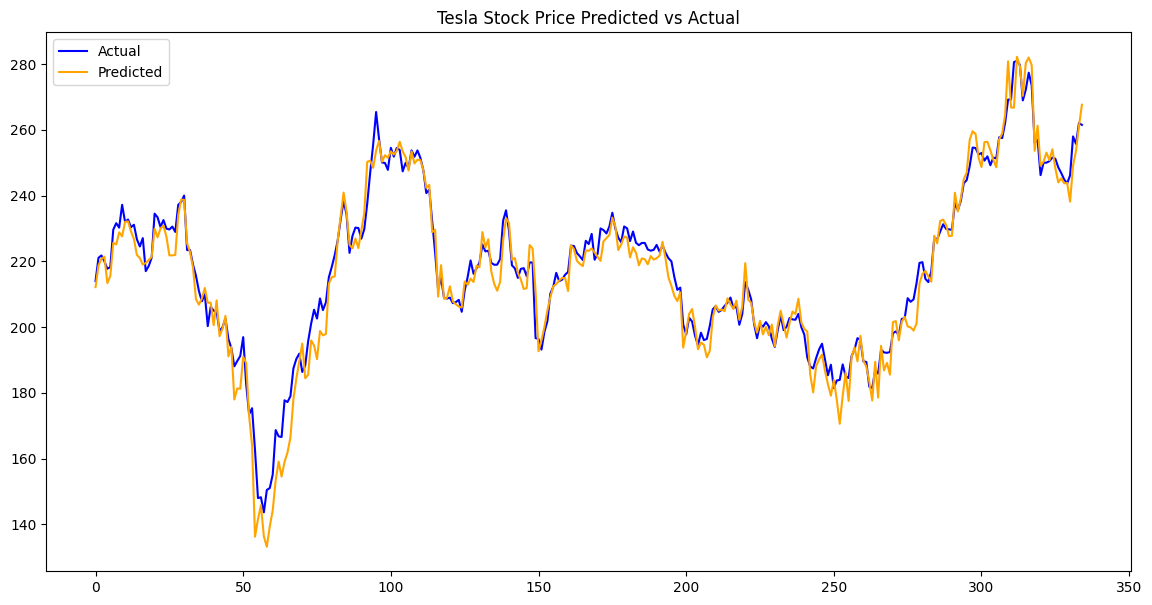

In [66]:
# visualize the prediction against the actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['y_test'].values, label='Actual', color='blue')
plt.plot(predictions_df['y_pred'].values, label='Predicted', color='orange')
plt.legend()
plt.title('Tesla Stock Price Predicted vs Actual')

In [67]:
# use classification metrics to evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 3.8285483718400184
Mean Squared Error: 27.493413703577676
R^2 Score: 0.955097928603007


### section report
  based on the visualization and classification metrics, the model makes a pretty good job on predicting the trend of tesla stock prices. The mse is 27, which is
  within a good tolerance. from the graph, we see the model tends to underpredict a bit since it's kind of below the actual line on those local minimas spans. To optimize the model, I would think of some hyperparameter tuning like gridsearch to decide the best n_components value from PCA , the best n_estimators and objective from XGBRegressor. I am pretty satisified with the prediction outcome XGBoost achieves in my case.